In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size,shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 4s 20ms/step - loss: 21.9679 - mae: 22.4630
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 21.0787 - mae: 21.5699
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 19.9720 - mae: 20.4666
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 20.5891 - mae: 21.0813
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 20.2777 - mae: 20.7735
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 19.6437 - mae: 20.1366
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 18.2940 - mae: 18.7848
Epoch 8/100
31/31 [==============================] - 0s 13ms/step - loss: 17.2657 - mae: 17.7576
Epoch 9/100
31/31 [==============================] - 0s 13ms/step - loss: 17.4906 - mae: 17.9840
Epoch 10/100
31/31 [==============================] - 0s 13ms/step - loss: 16.8689 - mae: 17.3590
Epoch 11/100
31/31 [=========

31/31 [==============================] - 0s 15ms/step - loss: 6.0910 - mae: 6.5761
Epoch 86/100
31/31 [==============================] - 0s 13ms/step - loss: 5.1708 - mae: 5.6530
Epoch 87/100
31/31 [==============================] - 0s 13ms/step - loss: 7.6221 - mae: 8.1111
Epoch 88/100
31/31 [==============================] - 0s 13ms/step - loss: 7.6670 - mae: 8.1527
Epoch 89/100
31/31 [==============================] - 0s 13ms/step - loss: 8.6166 - mae: 9.1056
Epoch 90/100
31/31 [==============================] - 0s 13ms/step - loss: 9.0588 - mae: 9.5436
Epoch 91/100
31/31 [==============================] - 0s 13ms/step - loss: 6.8620 - mae: 7.3472
Epoch 92/100
31/31 [==============================] - 0s 13ms/step - loss: 7.4907 - mae: 7.9747
Epoch 93/100
31/31 [==============================] - 0s 13ms/step - loss: 14.3848 - mae: 14.8774
Epoch 94/100
31/31 [==============================] - 0s 13ms/step - loss: 11.2916 - mae: 11.7796
Epoch 95/100
31/31 [=============================

(1e-08, 0.0001, 0.0, 30.0)

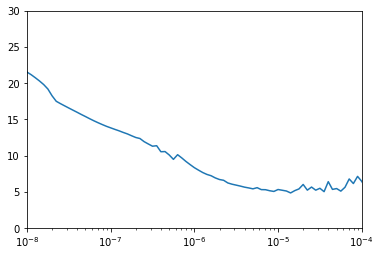

In [6]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

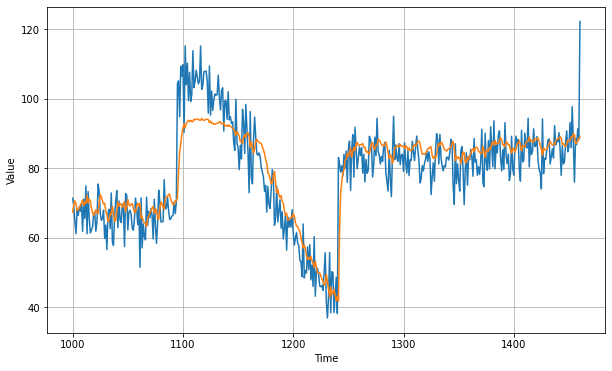

In [8]:
forecast = []
results = []

for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.7150693

<Figure size 432x288 with 0 Axes>

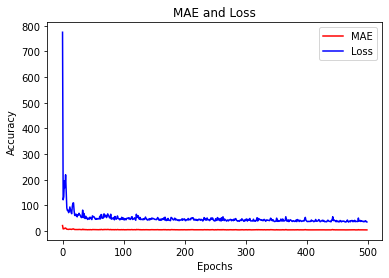

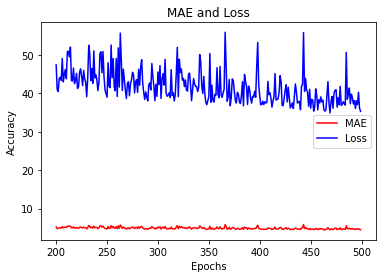

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

#Plot MAE and loss
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#Plot zoomed mae and loss
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [12]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 5s 21ms/step - loss: 250.9062
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 82.8759
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 75.3441
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 65.2872
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 63.7166
Epoch 6/100
31/31 [==============================] - 1s 21ms/step - loss: 53.8656
Epoch 7/100
31/31 [==============================] - 1s 20ms/step - loss: 57.8569
Epoch 8/100
31/31 [==============================] - 1s 20ms/step - loss: 58.2196
Epoch 9/100
31/31 [==============================] - 1s 21ms/step - loss: 55.7876
Epoch 10/100
31/31 [==============================] - 1s 21ms/step - loss: 56.4120
Epoch 11/100
31/31 [==============================] - 1s 21ms/step - loss: 45.9748
Epoch 12/100
31/31 [==============================] - 1s 21ms/step - loss: 57.5345
Epoch 13/100

31/31 [==============================] - 1s 20ms/step - loss: 43.4023
Epoch 100/100
31/31 [==============================] - 1s 20ms/step - loss: 54.9398


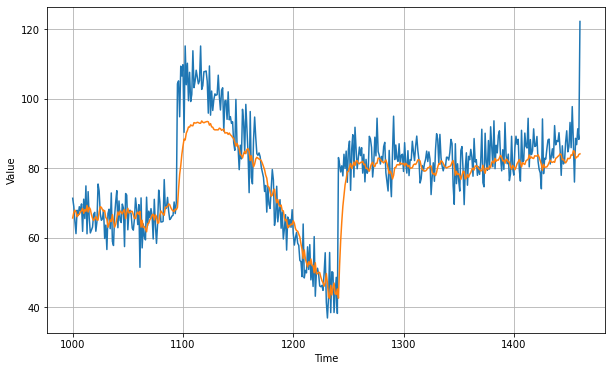

In [13]:
forecast = []
results = []

for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.7018046

<Figure size 432x288 with 0 Axes>

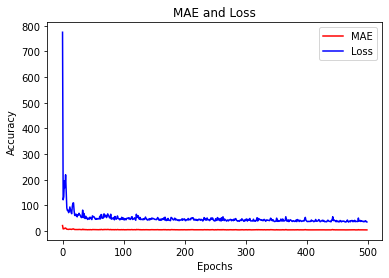

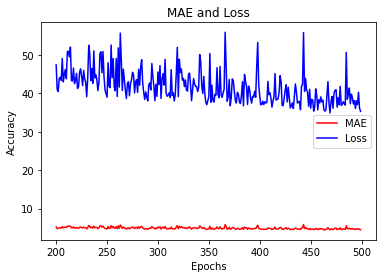

<Figure size 432x288 with 0 Axes>

In [15]:
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

#Plot MAE and loss
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#Plot zoomed mae and loss
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()